In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

from read_datasets import DATA_PATH
from multiprocessing import Pool # for reading the CSVs faster

# Read the data

In [2]:
def my_read_csv(filename):
    # Helper function for the parellel load_csvs
    return pd.read_csv(filename)

def load_csvs(prefix):
    """Reads and joins all our CSV files into one big dataframe.
    We do it in parallel to make it faster, since otherwise it takes some time.
    Idea from: https://stackoverflow.com/questions/36587211/easiest-way-to-read-csv-files-with-multiprocessing-in-pandas
    
    """

    # set up your pool
    pool = Pool() 
    file_list = [f"{DATA_PATH}/{prefix}{idx}.csv" for idx in range(1, 21)]
    df_list = pool.map(my_read_csv, file_list)

    # reduce the list of dataframes to a single dataframe
    return pd.concat(df_list, ignore_index=True)

In [3]:
%%time
icmc_df = load_csvs("icmc")
original_df = load_csvs("original")

CPU times: user 2.27 s, sys: 294 ms, total: 2.56 s
Wall time: 1min 58s




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Classify without processing

In [4]:
def run_models(x, y, processing="Nenhum",
               names=["3-NN", "5-NN", "7-NN", "MLP-1L", "MLP-2L"],
               models=[KNeighborsClassifier(n_neighbors=3), 
                       KNeighborsClassifier(n_neighbors=5), 
                       KNeighborsClassifier(n_neighbors=7),
                       MLPClassifier(solver="sgd", hidden_layer_sizes=(90, ), momentum=1),
                       MLPClassifier(solver="sgd", hidden_layer_sizes=(90, 40, ), momentum=0.3),
                      ], 
               result_cols=["Score", "Model", "Pré-Processamento"],
              other_metrics=False):
    
    model_results = []
    all_results = pd.DataFrame(columns=result_cols)
    results = pd.DataFrame(columns=["Confusion_Matrix", "Accuracy", "Precision", "Model", "Pré-Processamento"])

    for model, name in zip(models, names):
        # Confusion Matrix
        y_pred = cross_val_predict(model, x, y, cv=10, n_jobs=-1)
        conf_mat = confusion_matrix(y, y_pred)

        # Accuracy
        acc = accuracy_score(y, y_pred)

        # Precision
        #prc = precision_score(y, y_pred)
        prc = 0.5
        #precision_score(y, y_pred)

        results.loc[len(results)] = [conf_mat, acc, prc, name, processing]
        if other_metrics:
            pass
        else:
            # By default, cross_val_score is stratified by Y automatically!
            """For integer/None inputs, if the estimator is a classifier 
            and y is either binary or multiclass, StratifiedKFold is used. 
            """
            mean_score = cross_val_score(model, x, y, scoring="accuracy", 
                                         cv=10, n_jobs=-1).mean()
            model_results.append(mean_score)
            all_results.loc[len(all_results)] = [mean_score, name, processing]
    return all_results, results

In [5]:
icmc_results, icmc_matrix = run_models(icmc_df.drop(columns="target"), icmc_df["target"])

In [6]:
original_results, original_matrix = run_models(original_df.drop(columns="target"), icmc_df["target"])

## Show results

In [7]:
# Fonte: https://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
def plot_confusion_matrix(cm, name, dataset):
    plt.figure(figsize=(16,9))
    class_names = icmc_df["target"].unique()
    sns.heatmap(cm, square=True, annot=True, fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset}\nMatriz de Confusão: {name}')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')    
    plt.show()

In [8]:
def plot_results(results, name, use_hue=False):
    if use_hue:
        sns.barplot(y="Score", x="Model", data=results, hue="Pré-Processamento")
    else:
        sns.barplot(y="Score", x="Model", data=results)
    plt.xlabel("Modelo")
    plt.xlabel("Acurácia")
    plt.title(f"Accurácia entre os modelos para os dados {name}");

In [9]:
def plot_result(results, name, use_hue=False):
    # Confusion Matrix
    for i in range(len(results)):
        plot_confusion_matrix(results["Confusion_Matrix"][i], results["Model"][i], name)
    print()
    
    # Accuracy
    if use_hue:
        sns.barplot(y="Accuracy", x="Model", data=results, hue="Pré-Processamento")
    else:
        sns.barplot(y="Accuracy", x="Model", data=results)
    plt.xlabel("Modelo")
    plt.xlabel("Acurácia")
    plt.title(f"Acurácia entre os modelos para os dados {name}");
    plt.show()
    
    # Precision
    if use_hue:
        sns.barplot(y="Precision", x="Model", data=results, hue="Pré-Processamento")
    else:
        sns.barplot(y="Precision", x="Model", data=results)
    plt.xlabel("Modelo")
    plt.xlabel("Precisão")
    plt.title(f"Precisão entre os modelos para os dados {name}");
    plt.show()

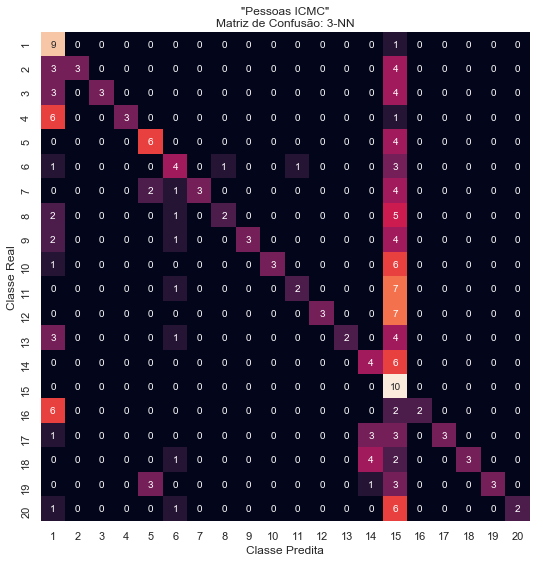

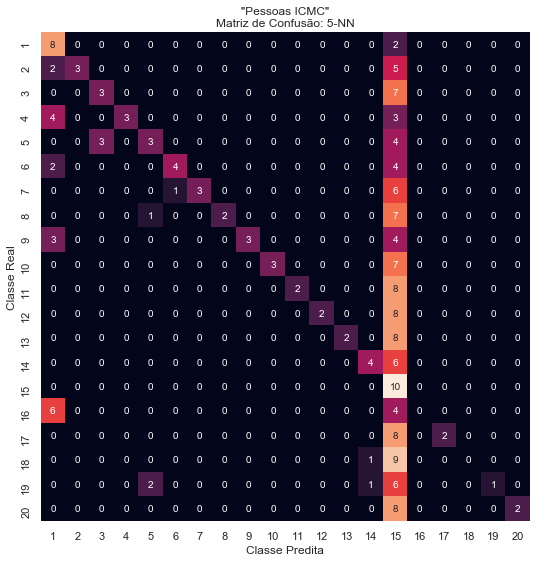

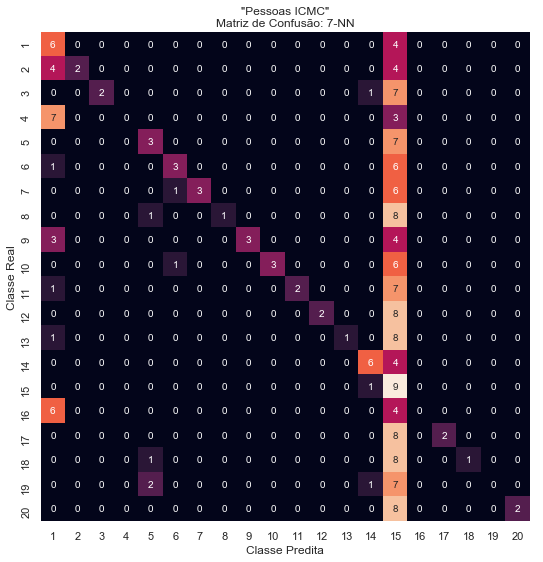

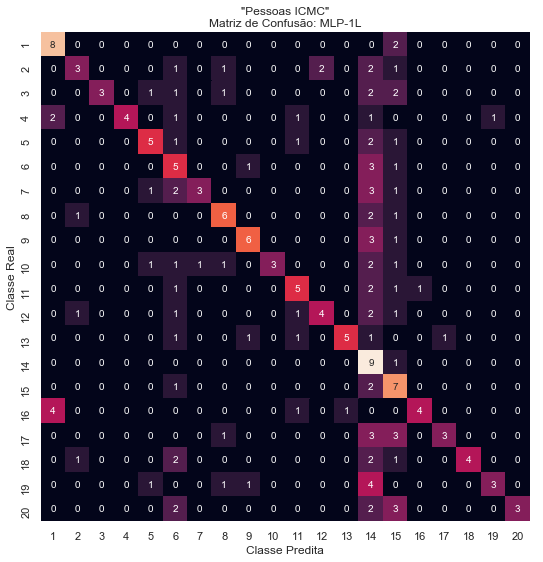

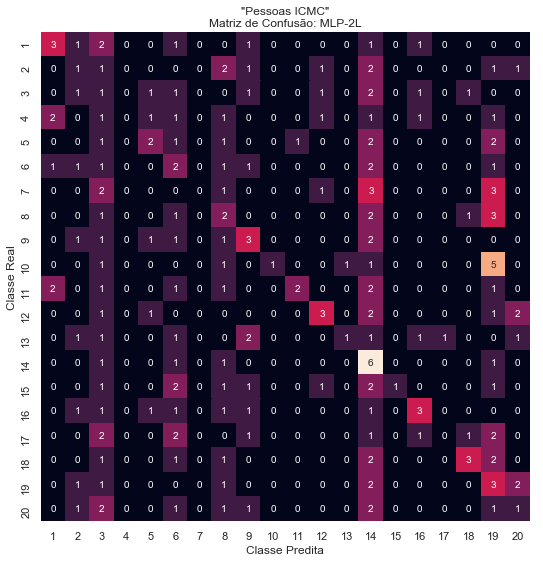

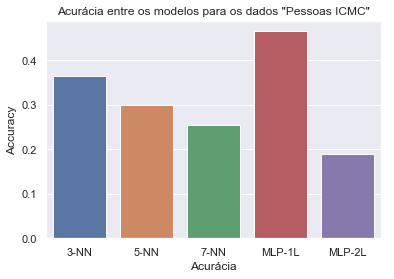

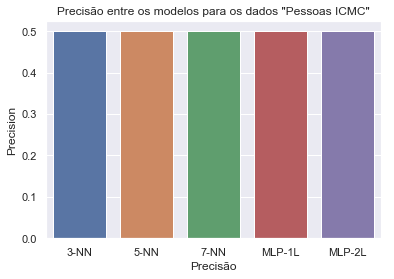

In [10]:
plot_result(icmc_matrix, "\"Pessoas ICMC\"")

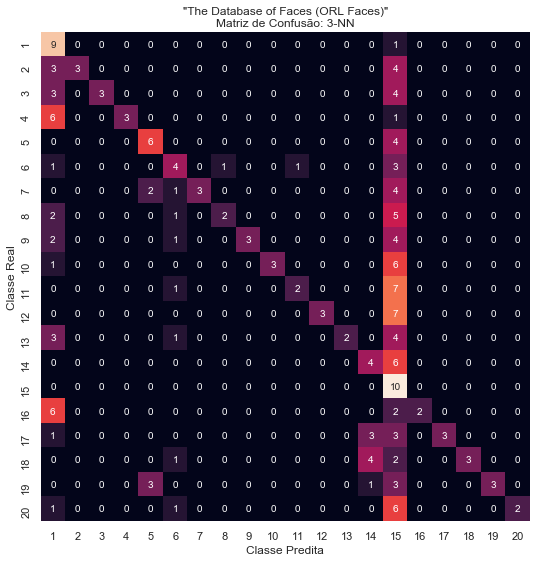

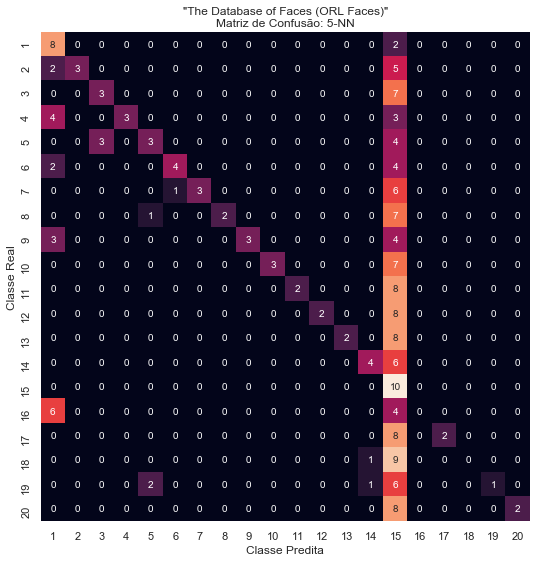

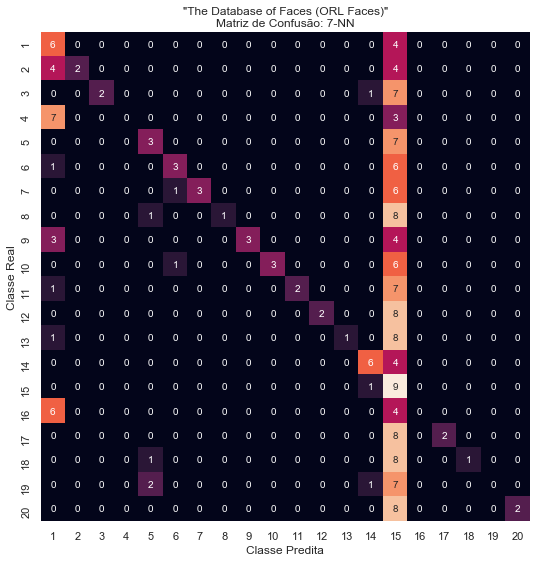

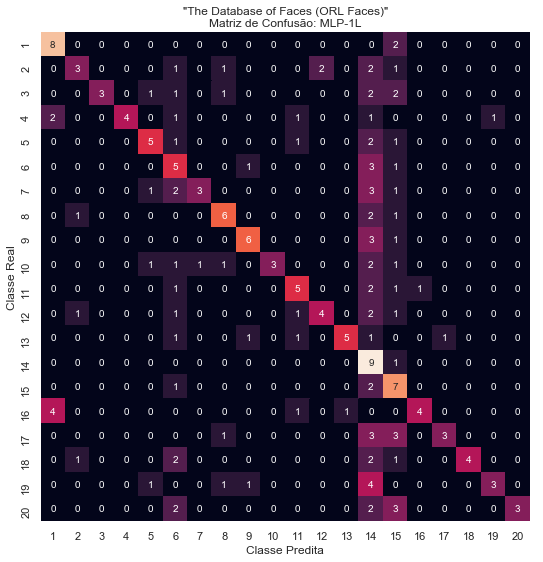

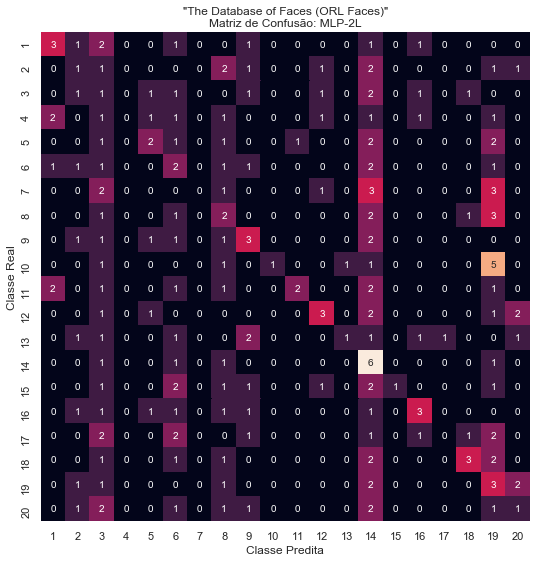

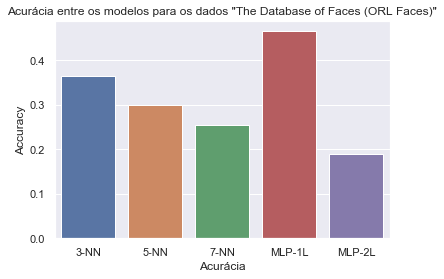

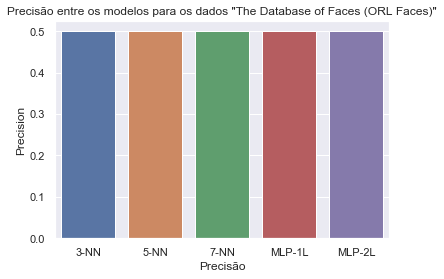

In [11]:
plot_result(icmc_matrix, "\"The Database of Faces (ORL Faces)\"")

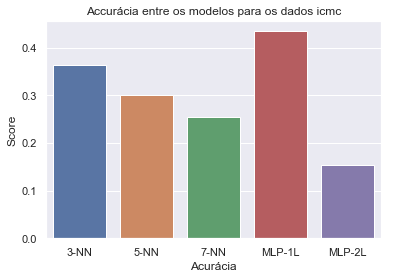

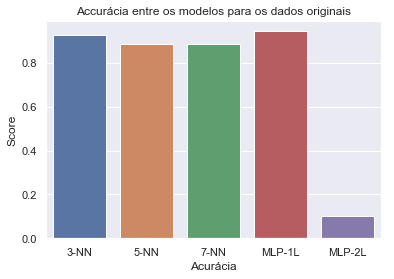

In [12]:
plot_results(icmc_results, "icmc")
plt.show()
plot_results(original_results, "originais")



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Apply PCA

In [13]:
def apply_pca(data, pca_percentage=0.5):
    # We must use "full" for solver otherwise we can't use a percentage
    pca =  PCA(n_components=pca_percentage,  svd_solver="full") 
    new_data = pca.fit_transform(data.drop(columns="target"))
    new_data = pd.DataFrame(new_data)
    new_data["target"] = data["target"].copy(deep=True)
    return new_data

In [14]:
%%time
original_pca = apply_pca(original_df)

CPU times: user 1.03 s, sys: 333 ms, total: 1.36 s
Wall time: 589 ms


In [15]:
%%time
icmc_pca = apply_pca(icmc_df)

CPU times: user 17.2 s, sys: 3.21 s, total: 20.4 s
Wall time: 5.87 s


In [16]:
icmc_results = icmc_results.append(run_models(icmc_pca.drop(columns="target"), 
                                              icmc_pca["target"], processing="PCA"),
                                   ignore_index=True)

TypeError: can only concatenate list (not "tuple") to list

In [ ]:
original_results = original_results.append(run_models(original_pca.drop(columns="target"), 
                                              original_pca["target"], processing="PCA"),
                                   ignore_index=True)

In [ ]:
plot_results(icmc_results, name="icmc", use_hue=True)

In [ ]:
plot_results(original_results, name="pca", use_hue=True)